## 1. Multi-class Weather Dataset
[Multi-class Weather Dataset](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset)은 다양한 기상 조건을 포함하는 이미지 데이터셋으로, 주로 기계 학습 및 딥러닝 모델을 학습하거나 평가하는 데 사용됩니다. 이 데이터셋은 맑음, 비, 눈, 흐림과 같은 여러 날씨 유형으로 라벨이 지정된 다중 클래스 분류 문제를 다룹니다. 각 클래스는 다양한 시간대, 계절, 지역에서 촬영된 이미지를 포함하여 현실 세계의 다양성을 반영하도록 설계되었습니다. 이를 통해 모델은 날씨 조건을 정확히 분류하고, 기상 관측, 자동화된 날씨 보고, 혹은 자율주행 차량의 환경 인식 시스템과 같은 다양한 응용 분야에서 활용될 수 있습니다.

In [2]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
#!/bin/bash
!kaggle datasets download pratik2901/multiclass-weather-dataset

Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/91.4M [00:00<?, ?B/s]
100% 91.4M/91.4M [00:00<00:00, 1.39GB/s]


In [4]:
import os
import zipfile
import random
from shutil import copyfile, rmtree

In [5]:
zip_file = 'multiclass-weather-dataset.zip'
base_dir = './Multi-class Weather Dataset'
train_dir = './train'
test_dir = './test'
extract_path = '.'  # 폴더 생성 없이 현재 디렉터리에 압축 해제

In [6]:
# 압축을 하거나 풀거나해줄 수 있는 모듈
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [7]:
# 분류 디렉터리 목록
categories = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

# 만약, 동일한 파일 있으면 지워라!
if os.path.exists(train_dir):
	# 하위 폴더도 다 삭제해라!
    rmtree(train_dir)
if os.path.exists(test_dir):
    # 하위 폴더도 다 삭제해라!
    rmtree(test_dir)

In [8]:
# train, test 폴더 및 하위 카테고리 폴더 생성
os.makedirs(train_dir, exist_ok=True)       # 만약 존재한다면 그대로 냅두겠다. exist_ok = True
os.makedirs(test_dir, exist_ok=True)

In [9]:
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

In [10]:
# 각 카테고리별 데이터 파일 나누기
for category in categories:
    category_path = os.path.join(base_dir, category)
    files = os.listdir(category_path)

    # 데이터 섞기
    random.shuffle(files)

    # 데이터 나누기 (8:2 비율)
    split_idx = int(len(files) * 0.8)
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    # 파일 복사
    for file in train_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(train_dir, category, file)
        copyfile(src, dst)

    for file in test_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(test_dir, category, file)
        copyfile(src, dst)

print("데이터 분리가 완료되었습니다.")

데이터 분리가 완료되었습니다.


In [11]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [12]:
# 데이터 증강
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),      # 이미지 크기가 제각각일 때
    transforms.RandomHorizontalFlip(),  # 랜덤으로 좌우반전. 확률 50%
    # RGB 이미지 : (H, W, C)  -> C : channal 보통 3개
    transforms.ToTensor(),              # Tensor로 바꿔줄 뿐 아니라 , 픽셀 값을 정규화시킴(0~1)
    # 변환 후 Tensor : (C, H, W)

    # [0.0 ~ 1.0] -> [-1.0 ~ 1.0] : 범위가 바뀐다.
    # 표준화를 하면 ReLU를 사용해도 죽은 기울기가 많이 줄어들 수 있다.
    # x = [0.2 , 0.4 , 0.7, 0.9] 모두 양수 -> ReLU에 의해서 그대로 통과 [0.2 , 0.4 , 0.7, 0.9]
    # x = [-0.8, -0.2, 0.3, 0.9] -> ReLU 통과 -> [0.0, 0.0, 0.3, 0.9]
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [13]:
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [14]:
# 데이터가 파일로 되어있기 때문에 -> 실제로 불러오기 해야함
# ImageFolder -> 파일을 읽고 이미지를 실제로 불러와주게 하는 모듈
train_dataset = datasets.ImageFolder(
    root='train/',
    transform=transform_train
)

In [15]:
dataset_size = len(train_dataset)       # 899
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size    # 719 180

# 데이터 나누기 -> randome_split
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### ※ transforms.ToTensor()

- 이미지를 PyTorch 텐서(tensor)로 변환합니다.
- 이미지의 픽셀 값을 [0, 255] 범위에서 [0.0, 1.0] 범위로 정규화합니다.
- 이미지의 차원을 (H, W, C) 형식에서 PyTorch에서 사용하는 (C, H, W) 형식으로 바꿉니다.
    - H: 이미지의 높이 (Height)
    - W: 이미지의 너비 (Width)
    - C: 채널(Channel; 예: RGB 이미지의 경우 3)

### ※ transforms.Normalize(mean, std)

- 텐서로 변환된 이미지의 픽셀 값을 정규화(normalization)합니다.
- mean: 각 채널(R, G, B)의 평균값.
std: 각 채널의 표준편차.
- mean=[0.5, 0.5, 0.5]: R, G, B 채널 각각의 평균을 0.5로 설정.
- std=[0.5, 0.5, 0.5]: R, G, B 채널 각각의 표준편차를 0.5로 설정.
- 이 정규화는 일반적으로 픽셀 값의 범위를 [−1,1][-1, 1][−1,1]로 조정하기 위해 사용됩니다. (픽셀 값이 [0,1][0, 1][0,1]로 변환된 상태에서)

### ※ ImageFolder

- datasets.ImageFolder는 이미지 데이터를 특정 디렉터리 구조에서 로드하는 클래스입니다.
- 디렉터리 이름을 레이블(class label)로 간주하며, 각 디렉터리 내의 이미지 파일들을 해당 레이블에 할당합니다.
- 이 클래스는 이미지 데이터를 PyTorch 데이터셋(Dataset) 형식으로 변환하므로, DataLoader와 함께 사용하여 배치 처리 및 데이터 증강(data augmentation)을 쉽게 적용할 수 있습니다.

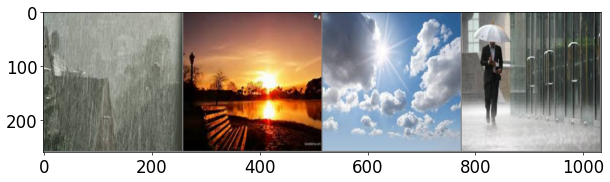

['Rain', 'Sunrise', 'Shine', 'Rain']


In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input):
    # torch.Tensor => numpy로 이용가능함. 유사 commutate
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean # 정규화 해제 (역정규화) -> 픽셀값 다시 살리기
    input = np.clip(input, 0, 1) # 값이 0보다 작은 경우 0, 1보다 큰 경우 1로 변환합니다.
    plt.imshow(input)
    plt.show()

class_names = {
    # 보통은 알파벳 순으로 지정한다.
    0:"Cloudy", 1:"Rain", 2:"Shine", 3:"Sunrise"
}

iterator = iter(train_dataloader)
imgs, labels = next(iterator)
out = make_grid(imgs[:4]) # 여러 이미지를 하나의 격자 형태로 합침
imshow(out)

print([class_names[labels[i].item()] for i in range(4)])

## 2. 다양한 모델 만들기

In [18]:
# 단일 선형 계층
# 활성화 함수나 추가 계층이 없으므로 모델이 표현할 수 있는 함수는 단순 선형 변환에 제한
# (256*256*3+1)*4 = 786,436

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3,4)       # 196,608
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        return x

In [19]:
# 두 개의 선형 계층을 사용하여 입력데이터를 단계적으로 압축
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 64)     # node가 64개 있다는 것 , layer가 하나 더 있다는 뜻!
        self.linear2 = nn.Linear(64, 4)                 # 64개를 받는 히든레이어
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

> 위에 Model1과 Model2는 히든 레이어가 있어도 선형인 모델이라, 의미가 없다.

In [47]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32,4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # 일단 다 펼친다.
        x = self.flatten(x)
        # 선형에 넣고 곡선화 시킨다. -> ReLU
        x = F.relu(self.linear1(x))
        # 과적합 방해를 위해 dropout
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = self.linear4(x)
        return x

### ※ nn.Module 상속

1 .모델 구성 요소 관리: 레이어와 파라미터를 자동으로 관리.
2. 순전파(Forward) 정의: forward() 메서드를 통해 간단하고 일관된 순전파 과정 정의.
3. 계층적 설계: 서브모듈을 활용해 복잡한 모델을 쉽게 설계.
4. 유틸리티 제공: 파라미터 저장/로드, 학습/추론 모드 전환 등 다양한 기능 제공.
5. PyTorch 호환성: 최적화, 데이터 로더 등 PyTorch의 다른
6. 기능과 손쉽게 통합.
추상화: 저수준 작업을 추상화하여 개발자의 생산성을 향상.

### ※ Dropout

nn.Dropout()은 PyTorch에서 제공하는 과적합(overfitting)을 방지하기 위한 레이어입니다. 드롭아웃은 학습 과정 중 일부 뉴런을 무작위로 "비활성화(drop)"함으로써, 모델이 특정 뉴런에 지나치게 의존하지 않도록 도와줍니다. 이를 통해 모델의 일반화 성능이 향상됩니다.

#### * traing 변수

In [35]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == 0:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

#### * validate 변수

In [36]:
def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():        # 검증 용도 : grad가 꺼지게끔
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == 0:
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

#### * test 변수

In [37]:
def test():
    start_time = time.time()
    print(f'[Test]')
    # 학습에 필요한 모든 메모리가 다 사리미
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == 0:
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [38]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.022077111527323723, running train accuracy: 0.265625
[Batch: 9] running train loss: 0.2568806291868289, running train accuracy: 0.616319477558136
train loss: 0.2963427792669835, accuracy: 0.6383866667747498
elapsed time: 6.075070381164551
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.20842115581035614, running val accuracy: 0.734375
val loss: 0.21135870085822211, accuracy: 0.699999988079071
elapsed time: 1.1082241535186768
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.26772844791412354, running train accuracy: 0.671875
[Batch: 9] running train loss: 0.26157600184281665, running train accuracy: 0.6909722089767456
train loss: 0.24926683799945262, accuracy: 0.6898469924926758
elapsed time: 4.949193000793457
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.274308443069458, running val accuracy: 0.734375
val loss: 0.40951064427693684, accuracy: 0.699999988079071
elapsed time: 1.64

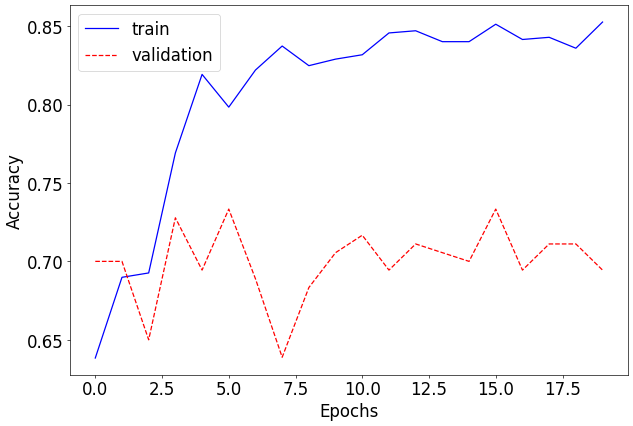

In [39]:
learning_rate = 0.01
log_step = 8

model = Model1()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

os.makedirs("weights/Model1", exist_ok=True)

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model1/best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"weights/Model1/last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.02188740111887455, running train accuracy: 0.265625
[Batch: 9] running train loss: 0.06486389309995705, running train accuracy: 0.5451388955116272
train loss: 0.0673054685513068, accuracy: 0.5591098666191101
elapsed time: 5.438812494277954
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.09861648827791214, running val accuracy: 0.53125
val loss: 0.11248834662967258, accuracy: 0.4888888895511627
elapsed time: 1.1537468433380127
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.1176147386431694, running train accuracy: 0.40625
[Batch: 9] running train loss: 0.13159559956855243, running train accuracy: 0.5503472089767456
train loss: 0.1840941435106938, accuracy: 0.5368567705154419
elapsed time: 4.9497246742248535
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.6527057886123657, running val accuracy: 0.59375
val loss: 0.9048596700032552, accuracy: 0.5222222208976746
elapsed time: 1.636

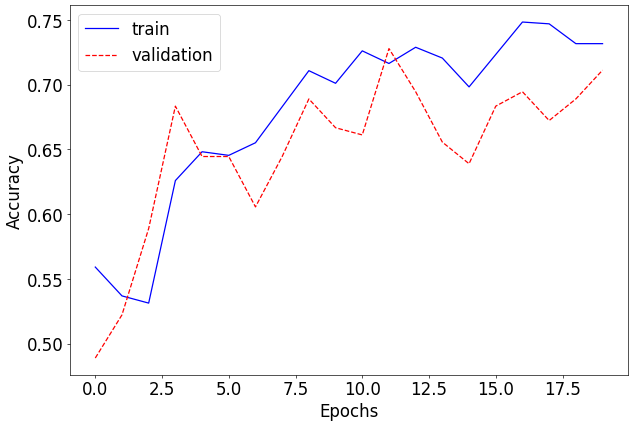

In [40]:
os.makedirs("weights/Model2", exist_ok=True)

learning_rate = 0.01
log_step = 8

model = Model2()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model2/best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"weights/Model2/last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.021539553999900818, running train accuracy: 0.265625
train loss: 0.020843992064161657, accuracy: 0.3963838815689087
elapsed time: 5.805190086364746
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.013546854257583618, running val accuracy: 0.5625
val loss: 0.01478749414285024, accuracy: 0.5833333730697632
elapsed time: 1.1123380661010742
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.016901347786188126, running train accuracy: 0.53125
train loss: 0.01789103040111579, accuracy: 0.5382475852966309
elapsed time: 4.973534107208252
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.010886058211326599, running val accuracy: 0.6875
val loss: 0.013446256518363953, accuracy: 0.6500000357627869
elapsed time: 1.1145148277282715
[Info] best validation accuracy!
[Epoch: 3 - Training]
[Batch: 1] running train loss: 0.01506823766976595, running train accuracy: 0.5625
train loss: 0.0160021267945312

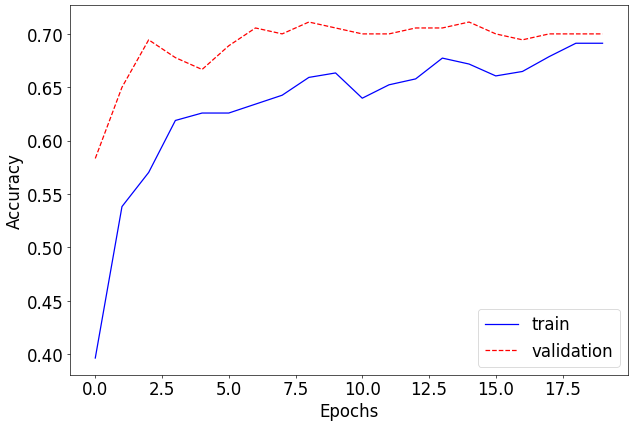

In [48]:
os.makedirs("weights/Model3", exist_ok=True)

learning_rate = 0.01
log_step = 20

model = Model3()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model3/best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"weights/Model3/last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")